In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
np.random.seed(42)

In [21]:
df = pd.read_csv("climate_change.csv")
df.head()

,Year,Month,MEI,CO2,CH4,N2O,CFC-11,CFC-12,TSI,Aerosols,Temp
0,1983,5,2.556,345.96,1638.59,303.677,191.324,350.113,1366.1024,0.0863,0.109
1,1983,6,2.167,345.52,1633.71,303.746,192.057,351.848,1366.1208,0.0794,0.118
2,1983,7,1.741,344.15,1633.22,303.795,192.818,353.725,1366.2850,0.0731,0.137
3,1983,8,1.130,342.25,1631.35,303.839,193.602,355.633,1366.4202,0.0673,0.176
4,1983,9,0.428,340.17,1648.40,303.901,194.392,357.465,1366.2335,0.0619,0.149


In [22]:
df.shape

(308, 11)

In [23]:
df.isnull().sum()

,0
Year,0
Month,0
MEI,0
CO2,0
CH4,0
N2O,0
CFC-11,0
CFC-12,0
TSI,0
Aerosols,0


In [24]:
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))
df.set_index('Date', inplace=True)

In [25]:
df.head()

,Year,Month,MEI,CO2,CH4,N2O,CFC-11,CFC-12,TSI,Aerosols,Temp
Date,,,,,,,,,,,
1983-05-01,1983,5,2.556,345.96,1638.59,303.677,191.324,350.113,1366.1024,0.0863,0.109
1983-06-01,1983,6,2.167,345.52,1633.71,303.746,192.057,351.848,1366.1208,0.0794,0.118
1983-07-01,1983,7,1.741,344.15,1633.22,303.795,192.818,353.725,1366.2850,0.0731,0.137
1983-08-01,1983,8,1.130,342.25,1631.35,303.839,193.602,355.633,1366.4202,0.0673,0.176
1983-09-01,1983,9,0.428,340.17,1648.40,303.901,194.392,357.465,1366.2335,0.0619,0.149


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [27]:
X = df.drop(columns=['Temp', 'Year', 'Month'])
y = df['Temp']

In [28]:
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
outliers = y[(y < (Q1 - 1.5 * IQR)) | (y > (Q3 + 1.5 * IQR))]
len(outliers)

0

In [29]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

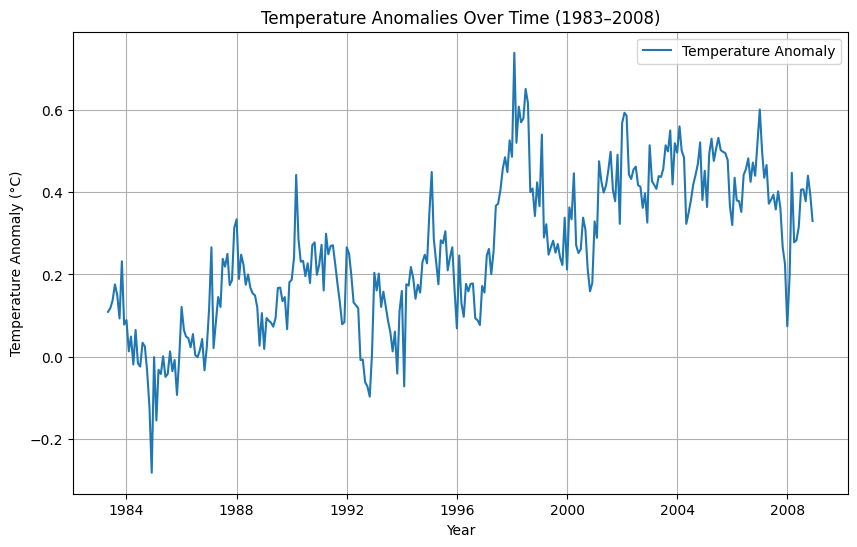

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Temp'], label='Temperature Anomaly')
plt.title('Temperature Anomalies Over Time (1983–2008)')
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.grid(True)
plt.savefig('temp_time_series.png')
plt.show()

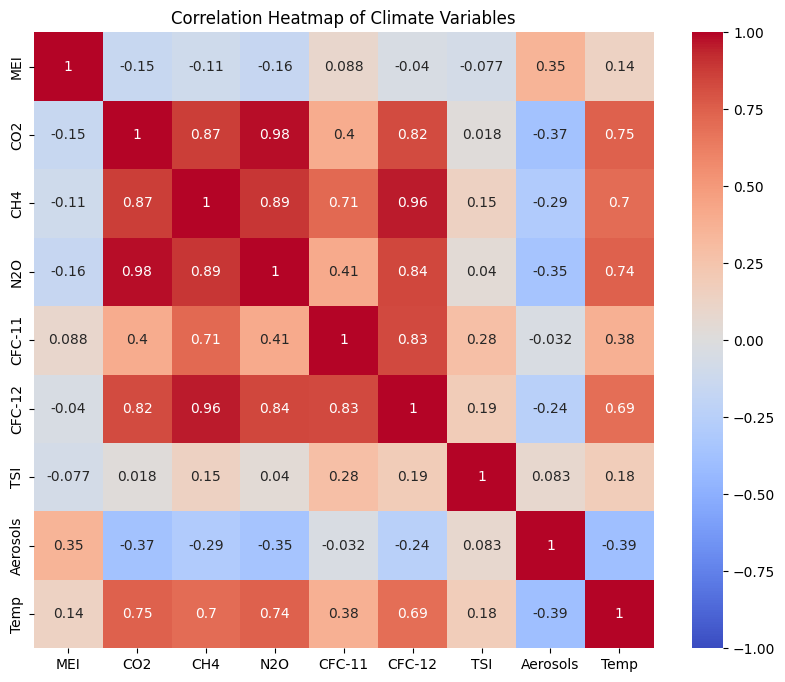

In [31]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(columns=['Year', 'Month']).corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Climate Variables')
plt.savefig('correlation_heatmap.png')
plt.show()

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [33]:
X_train.shape[0]

246

In [34]:
X_test.shape[0]

62

In [35]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [36]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [37]:
lr_pred = lr_model.predict(X_test)
rf_pred = rf_model.predict(X_test)

In [44]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [54]:
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)
lr_mae = mean_absolute_error(y_test, lr_pred)

In [55]:
print(f"Linear Regression - RMSE: {lr_rmse:.2f}, R-squared: {lr_r2:.2f}, MAE: {lr_mae:.2f}")

Linear Regression - RMSE: 0.10, R-squared: 0.70, MAE: 0.08


In [56]:
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)

In [57]:
print(f"Random Forest - RMSE: {rf_rmse:.2f}, R-squared: {rf_r2:.2f}, MAE: {rf_mae:.2f}")

Random Forest - RMSE: 0.08, R-squared: 0.82, MAE: 0.06


In [58]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

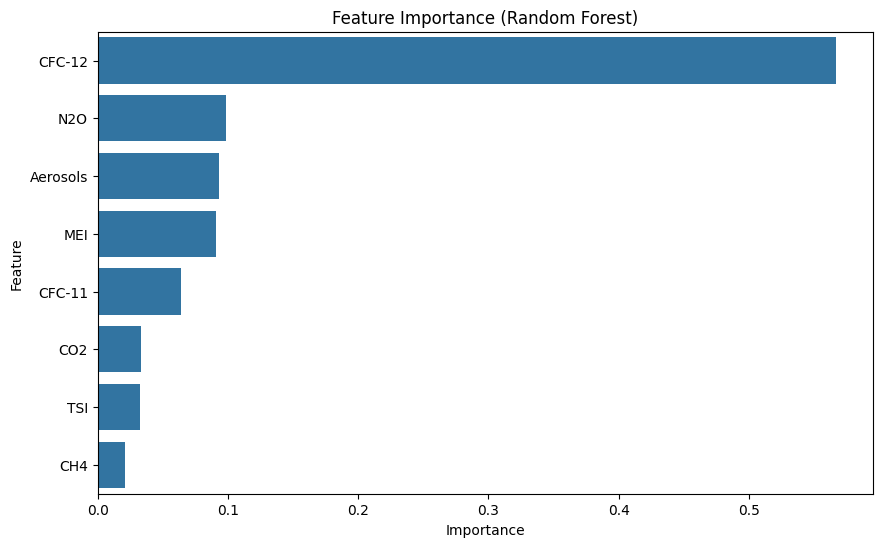

In [59]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

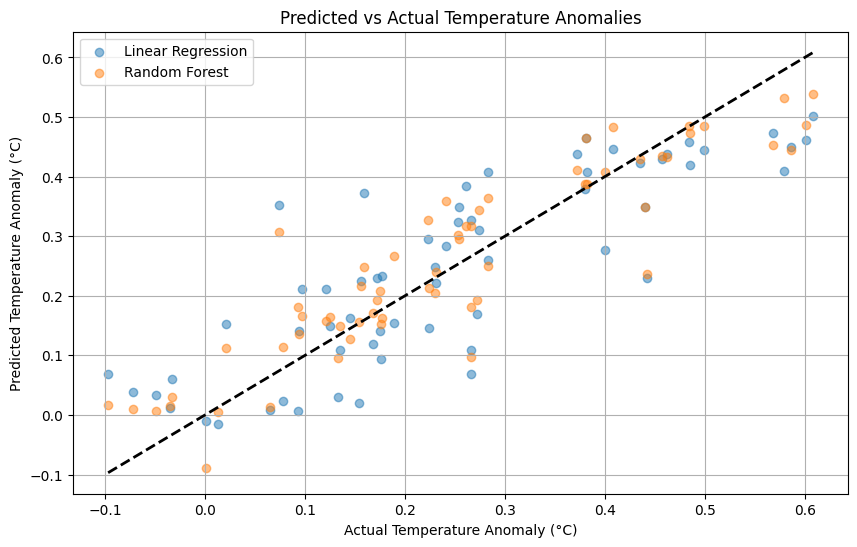

In [60]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lr_pred, label='Linear Regression', alpha=0.5)
plt.scatter(y_test, rf_pred, label='Random Forest', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Predicted vs Actual Temperature Anomalies')
plt.xlabel('Actual Temperature Anomaly (°C)')
plt.ylabel('Predicted Temperature Anomaly (°C)')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
df.to_csv('climate_change_preprocessed.csv')